In [13]:
import numpy as np
import pandas as pd
import pymc as pm
from matplotlib import pyplot as plt
import arviz as az
import seaborn as sns
#import aesara.tensor as at

In [16]:
# -----------------------------
# Load input/output CSVs
# -----------------------------
# wks = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18']
wks = ['01', '02', '03', '04', '05', '06']

df_input = pd.DataFrame()
df_output = pd.DataFrame()

for wk in wks:
    df = pd.read_csv("train/input_2023_w" + wk + ".csv", low_memory=False)
    df_input = pd.concat([df_input, df])
    df = pd.read_csv("train/output_2023_w" + wk + ".csv", low_memory=False)
    df_output = pd.concat([df_output, df])

# -----------------------------
# 1a. Determine final frame for each target
# -----------------------------
df_output_final = df_output.groupby(['game_id','play_id','nfl_id']).last().reset_index()

# Merge ball landing coordinates from input (assumes same for all rows per play)
ball_landing = df_input.groupby(['game_id','play_id'])[['ball_land_x','ball_land_y']].first().reset_index()
df_output_final = df_output_final.merge(ball_landing, on=['game_id','play_id'], how='left')

# Compute distance to landing spot
df_output_final['distance_to_ball'] = np.sqrt(
    (df_output_final['x'] - df_output_final['ball_land_x'])**2 +
    (df_output_final['y'] - df_output_final['ball_land_y'])**2
)

# -----------------------------
# 1b. Select target per play (closest to landing spot)
# -----------------------------
idx_min = df_output_final.groupby(['game_id','play_id'])['distance_to_ball'].idxmin()
df_targets = df_output_final.loc[idx_min].reset_index(drop=True)

# -----------------------------
# 1c. Success label: distance <= 0.5
# -----------------------------
df_targets['success'] = (df_targets['distance_to_ball'] <= 0.5).astype(int)

# -----------------------------
# 2. Extract pre-throw features for each target
# -----------------------------
feature_list = []

for _, row in df_targets.iterrows():
    g = row['game_id']
    p = row['play_id']
    target_id = row['nfl_id']
    
    # Target pre-throw frames
    df_play = df_input[(df_input['game_id']==g) & (df_input['play_id']==p)]
    df_target = df_play[df_play['nfl_id'] == target_id].sort_values('frame_id')
    
    if df_target.empty:
        continue  # skip if target not found in input

    # Kinematic features
    speed = df_target['s'].values
    accel = df_target['a'].values
    dir_change = np.abs(np.diff(df_target['dir'].values, prepend=df_target['dir'].values[0]))
    x = df_target['x'].values
    y = df_target['y'].values
    
    # Path features
    path_length = np.sum(np.sqrt(np.diff(x)**2 + np.diff(y)**2))
    straight_line = np.sqrt((x[-1]-x[0])**2 + (y[-1]-y[0])**2)
    curvature = path_length / (straight_line + 1e-6)  # avoid div by zero

    # Final frame features
    x_final = x[-1]
    y_final = y[-1]
    s_final = speed[-1]
    a_final = accel[-1]
    dir_final = df_target['dir'].iloc[-1]

    # Defender proximity features
    df_def = df_play[df_play['player_side'] == 'Defense']
    min_dists = np.sqrt((df_def['x'].values[:,None] - x[None,:])**2 + (df_def['y'].values[:,None] - y[None,:])**2)
    min_dists_per_frame = np.min(min_dists, axis=0)
    defender_min_dist_mean = np.mean(min_dists_per_frame)
    defender_min_dist_last = min_dists_per_frame[-1]
    
    feature_list.append({
        'game_id': g,
        'play_id': p,
        'target_nfl_id': target_id,
        'speed_final': s_final,
        'accel_final': a_final,
        'dir_final': dir_final,
        'path_length': path_length,
        'curvature': curvature,
        'defender_min_dist_mean': defender_min_dist_mean,
        'defender_min_dist_last': defender_min_dist_last,
        'success': row['success']
    })

df_features = pd.DataFrame(feature_list)
print(df_features.head())

        game_id  play_id  target_nfl_id  speed_final  accel_final  dir_final  \
0  2.023091e+09    101.0        44930.0         7.90         2.68      99.25   
1  2.023091e+09    194.0        54653.0         5.49         5.49     235.07   
2  2.023091e+09    219.0        53591.0         3.85         2.77     268.92   
3  2.023091e+09    361.0        38696.0         1.51         3.87      18.99   
4  2.023091e+09    436.0        53541.0         3.59         6.08     116.90   

   path_length  curvature  defender_min_dist_mean  defender_min_dist_last  \
0    11.773586   1.017687                2.459296                4.487003   
1    11.399626   1.401785                0.000000                0.000000   
2     4.620993   1.002363                5.005892                2.040221   
3    17.888180   1.046618                5.787652                1.599062   
4     4.892001   1.061012                4.246350                1.600312   

   success  
0      0.0  
1      0.0  
2      0.0  
3   

In [17]:
df_features['success'].mean()

0.17638633108246368

In [18]:
# Standardize features
features = ['speed_final','accel_final','dir_final','path_length','curvature',
            'defender_min_dist_mean','defender_min_dist_last']

X = (df_features[features] - df_features[features].mean()) / df_features[features].std()
y = df_features['success'].values

# Optional: encode target NFL id for hierarchical random intercepts
target_ids = df_features['target_nfl_id'].astype('category').cat.codes.values
n_targets = len(df_features['target_nfl_id'].unique())

In [19]:
# Ensure X is float64 NumPy array
X_values = X.astype(np.float64).values

with pm.Model() as model:
    # Hyperprior for target random intercepts
    sigma_target = pm.Exponential("sigma_target", 1.0)
    alpha_target = pm.Normal("alpha_target", mu=0, sigma=sigma_target, shape=n_targets)
    
    # Global intercept
    alpha = pm.Normal("alpha", mu=0, sigma=1)
    
    # Coefficients for predictors
    beta = pm.Normal("beta", mu=0, sigma=1, shape=X_values.shape[1])
    
    # Predictor matrix
    X_data = pm.Data("X_data", X_values)
    
    # Hierarchical intercepts need to be float
    target_idx = target_ids.astype(int)
    
    # Use pm.math.dot instead of at.dot
    logits = alpha + alpha_target[target_idx] + pm.math.dot(X_data, beta)
    
    # Likelihood
    y_obs = pm.Bernoulli("y_obs", logit_p=logits, observed=y)
    
    # Sample posterior
    trace = pm.sample(1000, tune=1000, target_accept=0.9)

/Users/clairefenton/bayes_final_project/.venv/lib/python3.11/site-packages/pymc/data.py:434: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_target, alpha_target, alpha, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 117 seconds.
There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [20]:
with model:
    ppc = pm.sample_posterior_predictive(trace)

# In PyMC v5, ppc is an InferenceData object
# Access posterior predictive samples
y_pred_samples = ppc.posterior_predictive["y_obs"].values  # shape: (chains, draws, n_observations)

# Combine chains and draws
y_pred_samples_flat = y_pred_samples.reshape(-1, y_pred_samples.shape[-1])

# Compute mean predicted probability per observation
y_pred_mean = y_pred_samples_flat.mean(axis=0)

df_features['pred_success_prob'] = y_pred_mean

Sampling: [y_obs]


In [21]:
with model:
    # Sample prior predictive and store as InferenceData
    prior_idata = pm.sample_prior_predictive(samples=1000, return_inferencedata=True)
    
    # Sample posterior
    posterior_idata = pm.sample(1000, tune=1000, return_inferencedata=True)
    
    # Sample posterior predictive (optional)
    posterior_pred = pm.sample_posterior_predictive(posterior_idata, return_inferencedata=True)

Sampling: [alpha, alpha_target, beta, sigma_target, y_obs]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_target, alpha_target, alpha, beta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 85 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
Sampling: [y_obs]


In [22]:
# Make a copy so we don't modify the original
idata = posterior_idata.copy()

# Add prior predictive as a separate group
idata.extend(prior_idata)

idata.extend(posterior_pred)

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'sigma_target'}>,
        <Axes: title={'center': 'sigma_target'}>]], dtype=object)

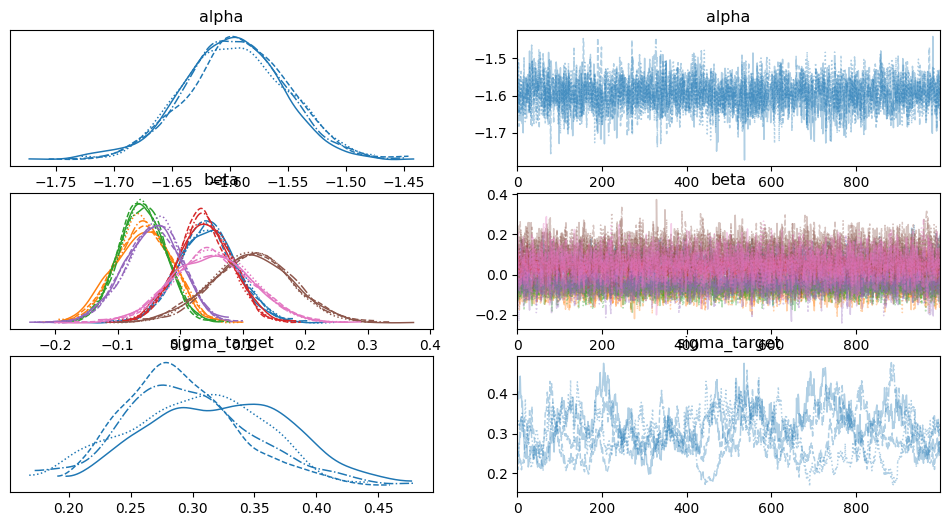

In [23]:
# Trace plot (posterior only)
az.plot_trace(idata, var_names=["alpha", "beta", "sigma_target"])

<Axes: title={'center': 'alpha'}>

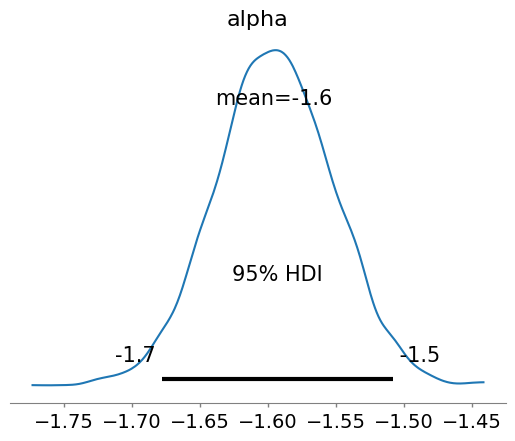

In [24]:
# Posterior vs prior for a variable
az.plot_posterior(idata, var_names=["alpha"], hdi_prob=0.95)

/Users/clairefenton/bayes_final_project/.venv/lib/python3.11/site-packages/arviz/plots/ppcplot.py:268: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/clairefenton/bayes_final_project/.venv/lib/python3.11/site-packages/arviz/plots/ppcplot.py:272: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y_obs / y_obs'>

/Users/clairefenton/bayes_final_project/.venv/lib/python3.11/site-packages/IPython/core/events.py:96: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/clairefenton/bayes_final_project/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


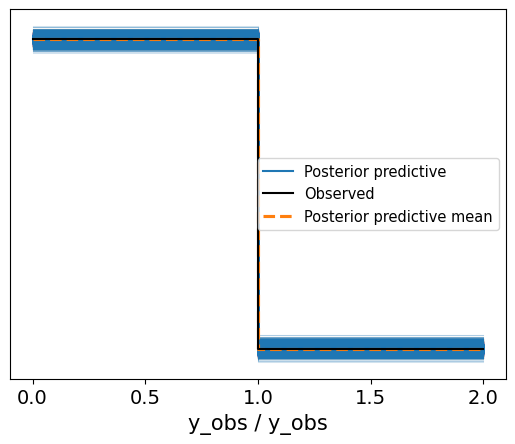

In [25]:
az.plot_ppc(idata, kind='kde', data_pairs={"observed": "y_obs"})

djdjdd

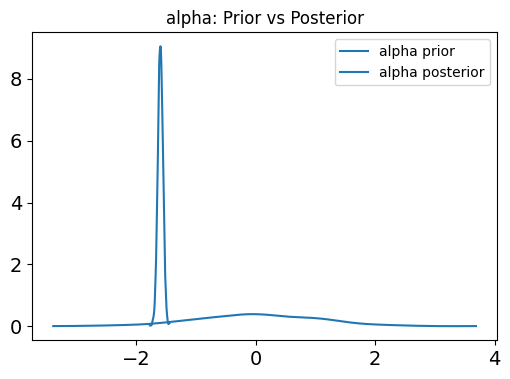

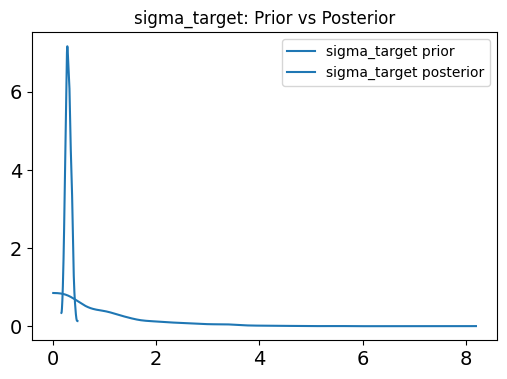

In [26]:
param_names = ["alpha", "sigma_target"]  # add any others you want

for p in param_names:
    plt.figure(figsize=(6,4))
    az.plot_dist(idata.prior[p], label=f"{p} prior")
    az.plot_dist(idata.posterior[p], label=f"{p} posterior")
    plt.legend()
    plt.title(f"{p}: Prior vs Posterior")
    plt.show()


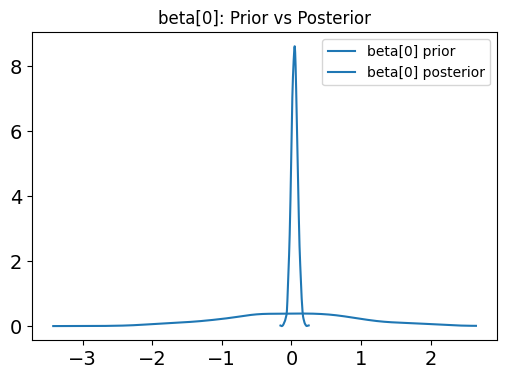

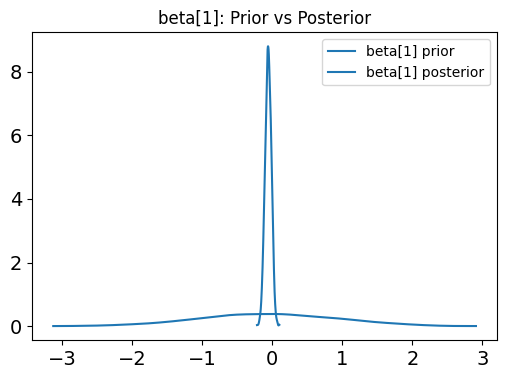

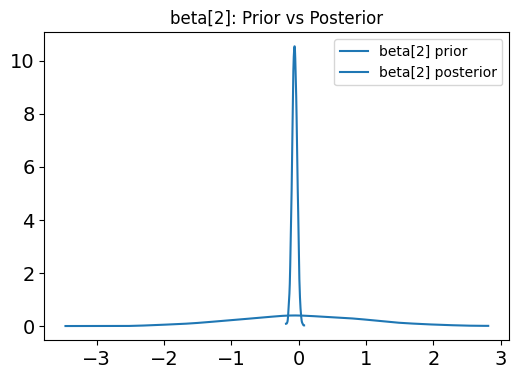

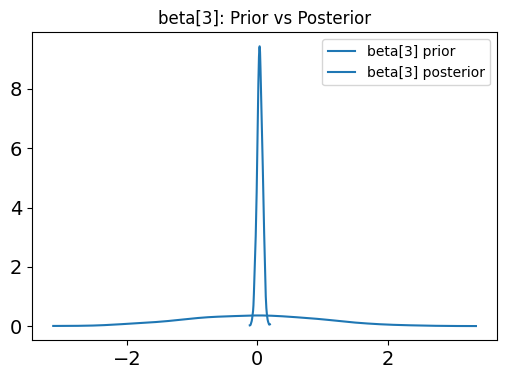

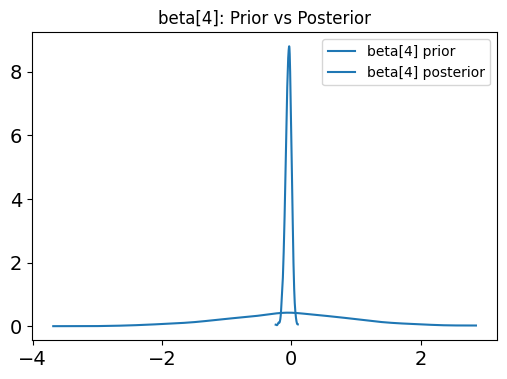

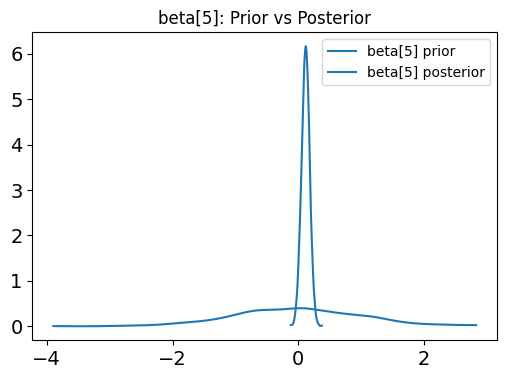

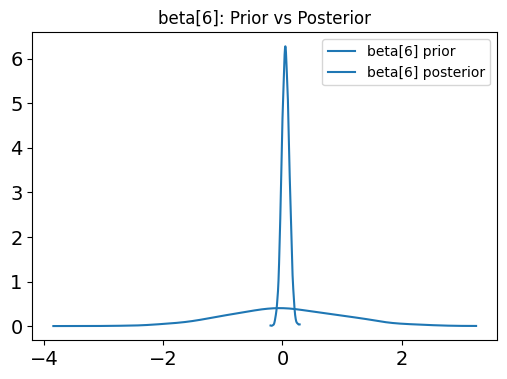

In [27]:
for i in range(idata.posterior["beta"].shape[2]):
    plt.figure(figsize=(6,4))
    az.plot_dist(idata.prior["beta"][:,:,i], label=f"beta[{i}] prior")
    az.plot_dist(idata.posterior["beta"][:,:,i], label=f"beta[{i}] posterior")
    plt.legend()
    plt.title(f"beta[{i}]: Prior vs Posterior")
    plt.show()


/var/folders/3c/ctpyt6nx3_7g8y9wdgfv8cy40000gn/T/ipykernel_37358/952499437.py:9: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


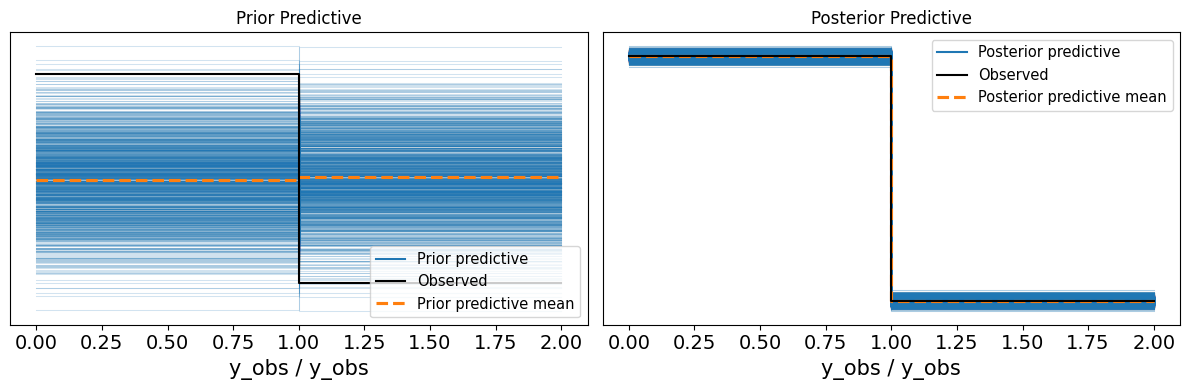

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))

az.plot_ppc(idata, group="prior", ax=axes[0], kind="kde")
axes[0].set_title("Prior Predictive")

az.plot_ppc(idata, group="posterior", ax=axes[1], kind="kde")
axes[1].set_title("Posterior Predictive")

plt.tight_layout()
plt.show()


<Axes: xlabel='y_obs / y_obs'>

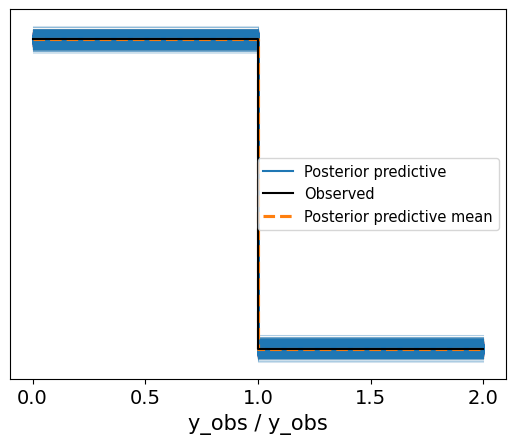

In [29]:
az.plot_ppc(idata, group="posterior", data_pairs={"success": "success"}, kind="kde")


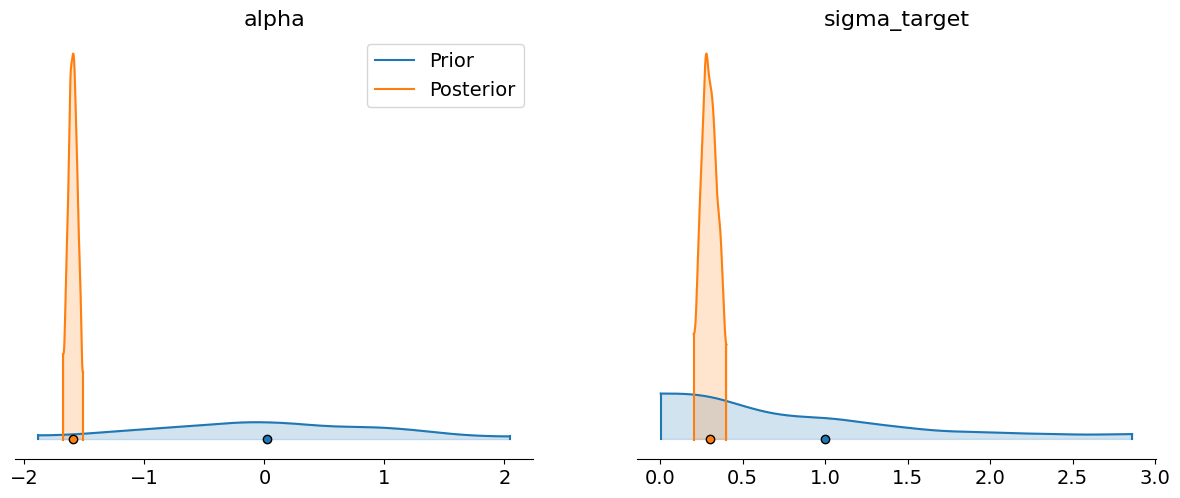

In [30]:
az.plot_density(
    [idata.prior, idata.posterior],
    data_labels=["Prior", "Posterior"],
    var_names=["alpha", "sigma_target"],
    shade=0.2
)
plt.show()
